In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from IPython import display
from sklearn.model_selection import train_test_split
%matplotlib inline

In [44]:
# Load the data
with np.load(os.path.join('data','cifar10-20k.npz'), allow_pickle=False) as npz_file:
    data = dict(npz_file.items())
    
y_full = data['labels']
names = data['names']
X_full = data['data'].reshape(-1, 32, 32, 3)

# normalize the data
X_full = X_full / 255

# set number of classes
num_classes = names.shape[0]

# Split data
from sklearn.model_selection import train_test_split

X_tr_full, X_te, y_tr_full, y_te = train_test_split(X_full, y_full, test_size=0.1, random_state=1)

# Split data again into training and cv
X_tr, X_cv, y_tr, y_cv = train_test_split(X_tr_full, y_tr_full, test_size=0.08, random_state=1)

print("X_tr", X_tr.shape)
print("X_cv", X_cv.shape)
print("X_te", X_te.shape)

X_tr (16560, 32, 32, 3)
X_cv (1440, 32, 32, 3)
X_te (2000, 32, 32, 3)


## Try with a larger data set

In [2]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
data1 = unpickle("data/cifar-10-batches-py/data_batch_1")
data2 = unpickle("data/cifar-10-batches-py/data_batch_2")
data3 = unpickle("data/cifar-10-batches-py/data_batch_3")
data4 = unpickle("data/cifar-10-batches-py/data_batch_4")
data5 = unpickle("data/cifar-10-batches-py/data_batch_5")
label_data = unpickle('data/cifar-10-batches-py/batches.meta')[b'label_names']

In [4]:
labels1 = data1[b'labels']
data1 = data1[b'data'] * 1.0
labels2 = data2[b'labels']
data2 = data2[b'data'] * 1.0
labels3 = data3[b'labels']
data3 = data3[b'data'] * 1.0
labels4 = data4[b'labels']
data4 = data4[b'data']  * 1.0
labels5 = data5[b'labels']
data5 = data5[b'data']  * 1.0

In [5]:
# Combine the remaining four arrays to use as training data
X_full = np.concatenate([data1, data2, data3, data4, data5], axis=0).reshape(-1, 32, 32, 3)
y_full = np.concatenate([labels1, labels2, labels3, labels4, labels5], axis=0)

# set number of classes
num_classes = len(label_data)

In [6]:
X_tr_full, X_te, y_tr_full, y_te = train_test_split(X_full, y_full, test_size=2000, random_state=1)

# Split data again into training and cv
X_tr, X_cv, y_tr, y_cv = train_test_split(X_tr_full, y_tr_full, test_size=2000, random_state=1)

print("X_tr", X_tr.shape)
print("X_cv", X_cv.shape)
print("X_te", X_te.shape)

X_tr (46000, 32, 32, 3)
X_cv (2000, 32, 32, 3)
X_te (2000, 32, 32, 3)


In [7]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

(5000, 32, 32, 3)

## Create the Model

In [51]:
## MODEL 2
# Create new graph
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = True
model_name = "model_5"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.002,               # start at 0.001
                                               global_step, 
                                               2000,                # 2000 steps
                                               0.9,                 # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    # Convolutional layer 1 
    conv1 = tf.layers.conv2d(
        X,                           # Input data
        filters=32,                  # 64 filters
        kernel_size=(3, 3),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 2
        padding='SAME',              # "same" padding
        activation=None,       # None
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
        name='conv1'                  # Add name
    )
    
    # try batch normalization
    bn1 = tf.layers.batch_normalization(
        conv1,
        axis=-1,
        momentum=0.99,
        epsilon=epsilon,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        training=training,
        name='bn1'
    )
    
    #apply relu
    conv1_bn_relu = tf.nn.relu(bn1)
    
    # Convolutional layer 2
    conv2 = tf.layers.conv2d(
        conv1_bn_relu,                           # Input data
        filters=32,                  # 64 filters
        kernel_size=(3, 3),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 2
        padding='SAME',              # "same" padding
        activation=None,       # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
        name='conv2'                  # Add name
    )
    
    # try batch normalization
    bn2 = tf.layers.batch_normalization(
        conv2,
        axis=-1,
        momentum=0.9,
        epsilon=epsilon,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        training=training,
        name='bn2'
    )
    
    #apply relu
    conv2_bn_relu = tf.nn.relu(bn2)
    
     # Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        conv2_bn_relu,                       # Input
        pool_size=(2, 2),            # Pool size: 3x3
        strides=(1, 1),              # Stride: 2
        padding='SAME',              # "same" padding
        name='pool1'
    )
    
    # try dropout here
    pool1 = tf.layers.dropout(pool1, rate=0.25, seed=1, training=training)
    
    # Convolutional layer 3
    conv3= tf.layers.conv2d(
        pool1,                       # Input
        filters=64,                  # 64 filters
        kernel_size=(3, 3),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 1
        padding='SAME',              # "same" padding
        activation=None,             # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
        name='conv3'                 # Add name
    )
    
    #norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    bn3 = tf.layers.batch_normalization(
        conv3,
        axis=-1,
        momentum=0.9,
        epsilon=epsilon,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        training=training,
        name='bn3'
    )
    
    #apply relu
    conv3_bn_relu = tf.nn.relu(conv3)
    
    # Convolutional layer 4
    conv4= tf.layers.conv2d(
        conv3_bn_relu,                       # Input
        filters=64,                  # 64 filters
        kernel_size=(3, 3),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 1
        padding='SAME',              # "same" padding
        activation=None,       # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
        name='conv4'                 # Add name
    )
    
    bn4 = tf.layers.batch_normalization(
        conv4,
        axis=-1,
        momentum=0.9,
        epsilon=epsilon,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        training=training,
        name='bn4'
    )
    
    #apply relu
    conv4_bn_relu = tf.nn.relu(bn4)
    
     # Max pooling layer 2 (2x2, stride: 2) - TUNED
    pool2 = tf.layers.max_pooling2d(
        conv4_bn_relu,                       # input
        pool_size=(3, 3),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME'
    )
    
    
    # try dropout here
    pool2 = tf.layers.dropout(pool2, rate=0.25, seed=1, training=training)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    
    ## TRY THIS
    # dropout at 50%
    # flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=1, training=training)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output,                 # input
        512,                         # 256 hidden units
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    ## TRY THIS
    # dropout at 50%
    fc1 = tf.layers.dropout(fc1, rate=0.50, seed=1, training=training)
    
    # Output layer
    logits = tf.layers.dense(
        fc1,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    with tf.variable_scope('conv2', reuse=True):
        conv_kernels2 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # THIS MAY BE NEEDED FOR BATCH NORM!!!
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [42]:
## CONFIGURE OPTIONS

init = False                   # whether to initialize the model or use a saved version

# Placeholders for metrics
valid_acc_values = []
valid_cost_values = []
train_acc_values = []
train_cost_values = []

# config
epochs = 20                    # how many epochs
print_every = 3                # how often to print metrics
checkpoint_every = 1           # how often to save model in epochs
use_gpu = True                 # whether or not to use the GPU
print_metrics = False           # whether to print or plot metrics, if False a plot will be created and updated every epoch

if use_gpu:
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.8
else:
    config = tf.ConfigProto(device_count = {'GPU': 0})

In [32]:
epochs = 20

In [ ]:
# reinitialize the step counter if neccessary, this is used for tensorboard logging
if not init:
    step_counter = 0

# train the model
with tf.Session(graph=graph, config=config) as sess:
    train_writer = tf.summary.FileWriter('./logs/train11', sess.graph)
    test_writer = tf.summary.FileWriter('./logs/test11')
    
    if not print_metrics:
        # create a plot to be updated as model is trained
        f, ax = plt.subplots(1,2,figsize=(20,5))
    
    # create the saver
    saver = tf.train.Saver()
    
    # If the model is new initialize variables, else restore the session
    if init:
        sess.run(tf.global_variables_initializer())
    else:
        saver.restore(sess, './model/cifar_'+model_name+'.ckpt')

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(epochs):
        # Accuracy values (train) after each batch
        batch_acc = []
        batch_cost = []

        for X_batch, y_batch in get_batches(X_tr, y_tr, 128):
            # Run training and evaluate accuracy
            _, _, summary, acc_value, cost_value = sess.run([train_op, extra_update_ops, merged, accuracy, mean_ce], feed_dict={
                X: X_batch,
                y: y_batch,
                training: True
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)
            batch_cost.append(cost_value)
            
            # write the summary
            train_writer.add_summary(summary, step_counter)
            step_counter += 1
            
        # save checkpoint every nth epoch
        if(epoch % checkpoint_every == 0):
            print("Saving checkpoint")
            # save the model
            save_path = saver.save(sess, './model/cifar_'+model_name+'.ckpt')
    
            # Now that model is saved set init to false so we don't need to constantly retrain it
            init = False
        
        # init batch arrays
        batch_cv_acc = []
        batch_cv_cost = []
        
        # Evaluate validation accuracy with batches so as to not crash the GPU
        for X_batch, y_batch in get_batches(X_cv, y_cv, 256):
            summary, valid_acc, valid_cost, lr = sess.run([merged, accuracy, mean_ce, learning_rate], feed_dict={
                X: X_batch,
                y: y_batch,
                training: False
            })
            
            batch_cv_acc.append(valid_acc)
            batch_cv_cost.append(valid_cost)
            
        # take the mean of the values to add to the metrics
        valid_acc_values.append(np.mean(batch_cv_acc))
        valid_cost_values.append(np.mean(batch_cv_cost))
        train_acc_values.append(np.mean(batch_acc))
        train_cost_values.append(np.mean(batch_cost))
        
        # we only need to add one set of logs for test data
        test_writer.add_summary(summary, step_counter)
        
        if print_metrics:
            # Print progress every fifth epoch to keep output to reasonable amount
            if(epoch % print_every == 0):
                print('Epoch {:02d} - step {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f} - lr: {:.5f}'.format(
                    epoch, step, valid_acc, np.mean(batch_acc), valid_cost, lr
                ))
        else:
            # draw a plot
            ax[0].cla()
            ax[0].plot(valid_acc_values, color="red", label="Validation")
            ax[0].plot(train_acc_values, color="blue", label="Training")
            ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))

            ax[0].set_xlabel('epoch')
            ax[0].set_ylabel('accuracy')
            ax[1].cla()
            ax[1].plot(valid_cost_values, color="red", label="Validation")
            ax[1].plot(train_cost_values, color="blue", label="Training")
            ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
            ax[1].set_xlabel('epoch')
            ax[1].set_ylabel('cost')
            ax[1].legend()
            ax[0].legend()

            display.display(plt.gcf())
            display.clear_output(wait=True)
        
    # print results of last epoch
    print('Epoch {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f}'.format(
                epochs, valid_acc, np.mean(batch_acc), valid_cost
            ))
    
    save_path = saver.save(sess, './model/cifar_'+model_name+'.ckpt')
    
    test_acc_values = []
    
    # Check on the test data
    for X_batch, y_batch in get_batches(X_te, y_te, 128):
        test_accuracy = sess.run(accuracy, feed_dict={
            X: X_batch,
            y: y_batch,
            training: False
        })
        test_acc_values.append(test_accuracy)
    
    test_acc = np.mean(test_acc_values)
    
    # Get 1st conv. layer kernels
    #kernels = conv_kernels.eval()
    #kernels2 = conv_kernels2.eval()

plt.show()

print("Convolutional network accuracy (test set):",test_acc)

In [ ]:
## MODEL 2
# Plot cost and accuracy and training and validation
f, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Convolutional network accuracy (test set):",test_acc)

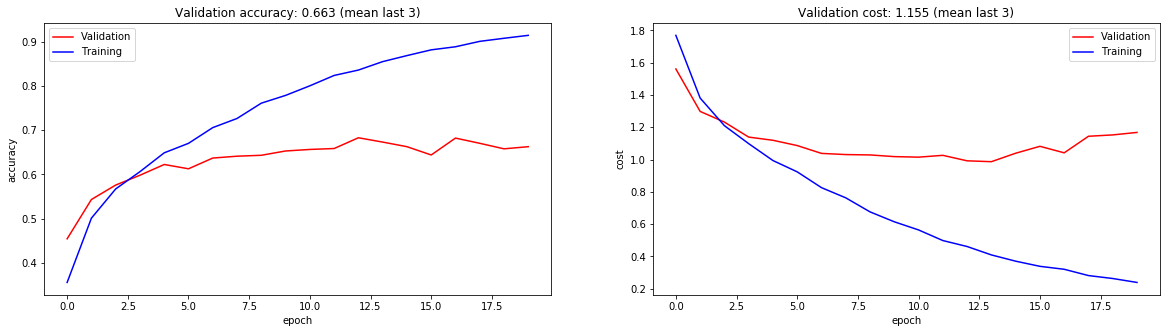

Convolutional network accuracy (test set): 0.69


In [7]:
## MODEL 1
# Plot cost and accuracy and training and validation
f, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Convolutional network accuracy (test set):",test_acc)

In [3]:
## MODEL 1
# Create new graph
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = True
model_name = "model3"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.001,               # start at 0.001
                                               global_step, 
                                               2000,                # 2000 steps
                                               0.95,                 # 0.95 increment
                                               staircase=True)
    
    # Convolutional layer 1 
    conv1 = tf.layers.conv2d(
        X,                           # Input data
        filters=64,                  # 64 filters
        kernel_size=(5, 5),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 2
        padding='SAME',              # "same" padding
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
        name='conv1'                  # Add name
    )
    
     # Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        conv1,                       # Input
        pool_size=(3, 3),            # Pool size: 3x3
        strides=(2, 2),              # Stride: 2
        padding='SAME',              # "same" padding
        name='pool1'
    )
    
    # try dropout here
    #pool1 = tf.layers.dropout(pool1, rate=0.25, seed=1, training=training)
    
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    
    # Convolutional layer 2
    conv2 = tf.layers.conv2d(
        norm1,                       # Input
        filters=64,                  # 64 filters
        kernel_size=(5, 5),          # Kernel size: 5x5
        strides=(1, 1),              # Stride: 1
        padding='SAME',              # "same" padding
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
        name='conv2'                 # Add name
    )
    
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    
     # Max pooling layer 2 (2x2, stride: 2) - TUNED
    pool2 = tf.layers.max_pooling2d(
        norm2,                       # input
        pool_size=(3, 3),            # pool size 2x2
        strides=(2, 2),              # stride 2
        padding='SAME'
    )
    
    # try dropout here
    pool2 = tf.layers.dropout(pool2, rate=0.25, seed=1, training=training)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    
    ## TRY THIS
    # dropout at 50%
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=1, training=training)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output,                 # input
        384,                         # 256 hidden units
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    ## TRY THIS
    # dropout at 50%
    # fc1 = tf.layers.dropout(fc1, rate=0.30, seed=1, training=training)
    
    # Fully connected layer
    fc2 = tf.layers.dense(
        fc1,                 # input
        192,                         # 256 hidden units
        activation=tf.nn.relu,       # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    ## TRY THIS
    # dropout at 75%
    # fc2 = tf.layers.dropout(fc2, rate=0.75, seed=1, training=training)
    
    
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    with tf.variable_scope('conv2', reuse=True):
        conv_kernels2 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./train', sess.graph)
    test_writer = tf.summary.FileWriter('./test')